### Classifying Ancient Egyptian Landmarks

Created by Josh Sanchez. Last updated February 1, 2024.

This dataset consists of roughly 3,500 images of Ancient Egyptian landmarks.
The dataset was created by user Marvy Ayman Halim on Kaggle and can be found at: https://www.kaggle.com/datasets/marvyaymanhalim/ancient-egyptian-landmarks-dataset.

In [29]:
# data preprocessing
import os
import shutil
import pandas as pd
import numpy as np

# data visualization
%matplotlib inline
from matplotlib import pyplot as plt
from pylab import *
import mglearn

# data scaling
from preamble import *
from sklearn.model_selection import train_test_split

# data analysis
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data Preprocessing
Import the data and clean up the folder and file names. Then make the image dataset into a .csv file. 

**Note:** I manually removed the Node.js folder from the dataset because it does not pertain to the project. The original data can be found under the folder called *Data*. The *raw_data* folder contains the original dataset minus the Node.js folder. The *processed_data folder* contains the properly formatted folder and file names.

Ensure that you do not have a processed_data folder on your machine, just the raw_data folder, before you run the following cell.

In [9]:
filenames = []
labels = []

# create the processed_data folder
try:
    os.mkdir(os.path.join(os.getcwd(), "processed_data"))
except OSError as error:
    print(error)

processed_data_dir = os.path.join(os.getcwd(), "processed_data")

for folder in os.scandir("raw_data"):

    # if the selected item is not a directory
    if not folder.is_dir():
        continue


    # lowercase the folder name and replace space with underscore
    changed_folder_name = folder.name.lower()

    changed_folder_name = changed_folder_name.replace(" ", "_")


    # add folder to processed_data
    try:
        os.mkdir(os.path.join(processed_data_dir, changed_folder_name))
    except OSError as error:
        print(error)

    processed_folder = os.path.join(processed_data_dir, changed_folder_name)

    # pull filename and store in filenames for dataframe
    for file in os.scandir(folder.path):
        # if the folder is empty
        if len(folder.path) == 0:
            continue

        # lowercase the file name and replace space with underscore
        changed_file_name = file.name.lower()

        changed_file_name = changed_file_name.replace(" ", "_")


        # copy the file to its correct folder in processed_data
        shutil.copy(file, processed_folder)

        # rename the file to the edited file name
        raw_file = os.path.join(processed_folder, file.name)                 # the original, unedited file name
        processed_file = os.path.join(processed_folder, changed_file_name)   # the edited file name

        try:
            os.rename(raw_file, processed_file)
        except OSError as error:
            print(error)

        # store properly formatted folder name as a label
        labels.append(changed_folder_name)

        # store filename as a filename
        filenames.append(changed_file_name)

        # create a dataframe by making a tuple of the filename and label
        df = pd.DataFrame(list(zip(filenames, labels)), columns=["image", "label"])

# change the file to a csv

df.to_csv("ancient_egyptian_dataset.csv", index=False)

# Describe the sample and features

In [13]:
df.head(10)

,image,label
0,15634726773_a8ac65d6ef_m_-_copy.jpg,akhenaten
1,19281291360_5a49331215_m.jpg,akhenaten
2,2906415757_50c2bc0414_m.jpg,akhenaten
3,41957529164_421e9f622f_m.jpg,akhenaten
4,4902788942_1c4ee56ede_m.jpg,akhenaten
5,7731634374_fe4e21a493_m.jpg,akhenaten
6,9711457465_051cf60521_n.jpg,akhenaten
7,a.1.jpg,akhenaten
8,a.10.jpg,akhenaten
9,a.11.jpg,akhenaten


# Understanding patterns/trends in the data

In order to understand the data, it must first be described. The code below shows that there are 1337 "unique" images (meaning image filenames) and 22 unique labels. At this point, the model might attempt to cluster the images into 22 distinct groups.

In [ ]:
df.describe()

The below code shows the number of images for each label. This is the number of points expected for each cluster.

In [ ]:
df["label"].value_counts()

# Data transformations
Scale and then grayscale images. Overwrite the image file in processed_data with the transformed images.

In [3]:
def resize_with_aspect_ratio(image, size):
    """Resizes an image with padding to maintain aspect ratio.

    Args:
        image: A PIL.Image.Image object.
        size: Tuple representing the desired output size (width, height).

    Returns:
        A PIL.Image.Image object of the resized image.
    """

    # if the image is already a square
    if image.width == image.height:
        square_img = image.resize(size)
        # print("image is already a square- resize without padding: ", square_img.size)

        return square_img

    # if the image's height is smaller than its width
    elif image.width > image.height:
        # pad the image with black bars to get the image to a square size of its width
        square_img = Image.new(image.mode, (image.width, image.width))
        square_img.paste(image, (0, (image.width - image.height) // 2))

        # resize the image
        resized_img = square_img.resize(size)
        # print("image height is smaller than width- resize with padding for height: ", resized_img.size)

        return resized_img

    # if the image's width is smaller than its height
    else:
        square_img = Image.new(image.mode, (image.height, image.height))
        square_img.paste(image, ((image.height - image.width) // 2, 0))

        # resize the image
        resized_img = square_img.resize(size)
        # print("image width smaller than height- resize with padding for width: ", resized_img.size)

        return resized_img

In [4]:
def resize_and_grayscale(image_path):
    """Resizes and grayscales an image.

    Args: image_path: String representing the path to the image file.

    Returns: A PIL.Image.Image object of the resized and grayscale image.
    """

    image = Image.open(image_path)
    size = (180, 180)

    # If the image is already 180x180, just grayscale it
    if image.size == size:
        gray_image = image.convert("L")  # Convert to grayscale
        return gray_image

    # Resize with padding or direct resizing based on aspect ratio
    resized_img = resize_with_aspect_ratio(image, size)

    # Convert to grayscale
    gray_img = resized_img.convert("L")

    # Save the grayscale image
    gray_img.save(image_path)

    return gray_img

In [5]:
def display_image(image_list, index):
    """Displays a specific image from a specified image_list.
    
    Args: image_list: List containing either the non aspect preserved or the aspect preserved NumPy representations of the images.
    
    Returns: A PIL.Image object of the image.
    """
    # Acces the specific NumPy array from the list
    img_array = image_list[index]

    # Convert the NumPy array to a PIL Image object (assuming uint8 data type)
    img = Image.fromarray(img_array.astype("uint8"))

    return img

In [10]:
# Resize and grayscale all the images without preserving aspect ratio
img_list = []
for image, label in df.values:
    img_path = os.path.join(processed_data_dir, label, image)

    try:
        # Open image using PIL
        img = Image.open(img_path)

        # Resize the image
        resized_img = img.resize((180, 180))  # This does not preserve aspect ratio

        # Convert to grayscale
        gray_img = resized_img.convert("L")

        # Append the resized and grayscaled image to the list
        img_list.append(np.array(gray_img))
    except FileNotFoundError:
        print(f"Error: Image not found - {img_path}")  # Handle file not found error

# img_list is a list of NumPy arrays representing the processed images

In [11]:
# Resize and grayscale all the images preserving aspect ratio

img_list_aspect_preserved = []
for image, label in df.values:
    img_path = os.path.join(processed_data_dir, label, image)

    try:
        # Open image using PIL
        img = Image.open(img_path)

        # Resize and grayscale the image
        resized_and_grayscaled_img = resize_and_grayscale(img_path)

        # Append the resized and grayscaled image to the list
        img_list_aspect_preserved.append(np.array(resized_and_grayscaled_img))
    except FileNotFoundError:
        print(f"Error: Image not found - {img_path}")  # Handle file not found error

# img_list_aspect_preserved is a list of NumPy arrays representing the processed images

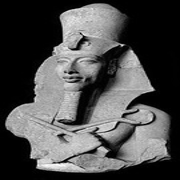

In [12]:
# Show the first image of the non aspect preserved list
index = 0
display_image(img_list, index)

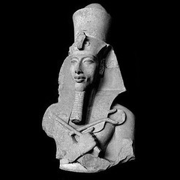

In [13]:
# Show the image of the aspect preserved list
display_image(img_list_aspect_preserved, 0)

# Contours
The cells below will show the contours of some of the images.

(0.5, 179.5, 0.5, 179.5)

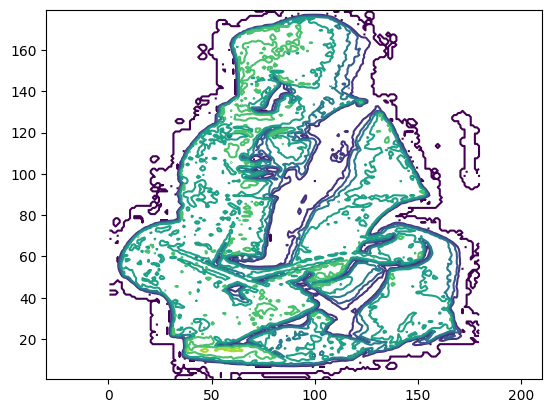

In [14]:
# Show the contours of the first image without preserved aspect ratio
figure()
contour(img_list[0], origin='image')
axis('equal')

(0.5, 179.5, 0.5, 179.5)

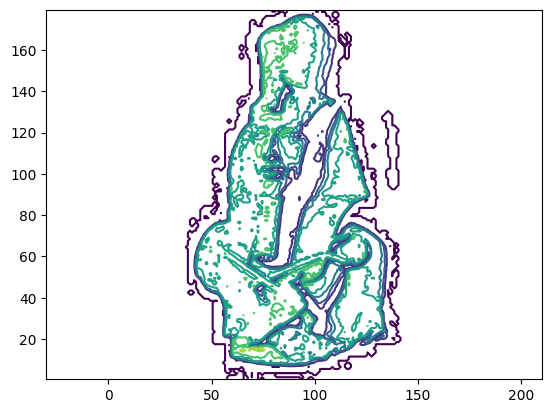

In [15]:
# Show the contours of the first image with preserved aspect ratio
figure()
contour(img_list_aspect_preserved[0], origin='image')
axis('equal')

(0.5, 179.5, 0.5, 179.5)

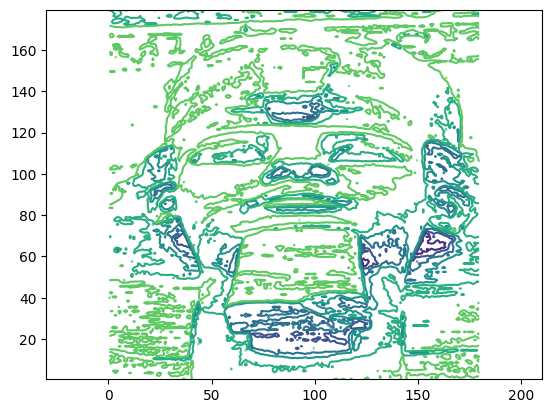

In [16]:
# Show the contours for the last image in the dataset without preserved aspect ratio
figure()
contour(img_list[3574], origin="image")
axis("equal")

(0.5, 179.5, 0.5, 179.5)

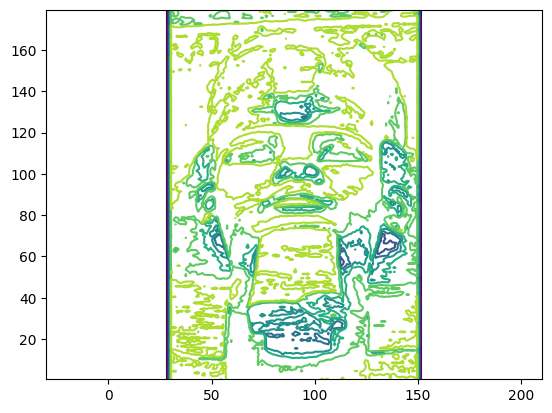

In [17]:
# Show the contours for the last image in the dataset with preserved aspect ratio
figure()
contour(img_list_aspect_preserved[3574], origin="image")
axis("equal")

(0.5, 179.5, 0.5, 179.5)

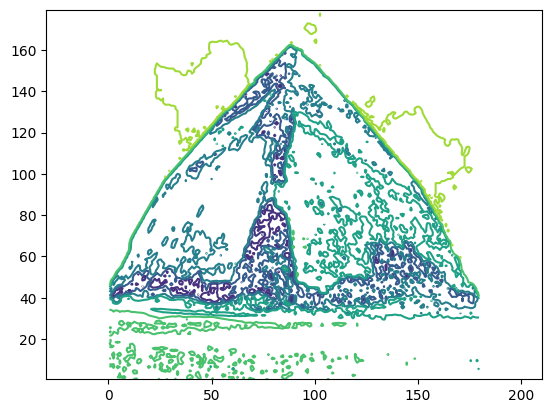

In [18]:
# Show the contours for the bent_pyramid_for_senefru without preserved aspect ratio
figure()
contour(img_list[194], origin="image")
axis("equal")

(0.5, 179.5, 0.5, 179.5)

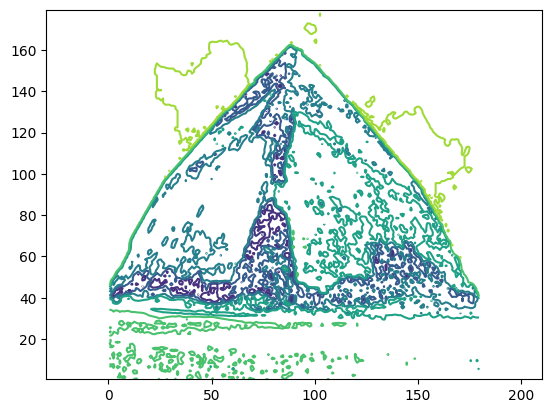

In [19]:
# Show the contours for the bent_pyramid_for_senefru with preserved aspect ratio
figure()
contour(img_list_aspect_preserved[194], origin="image")
axis("equal")

# Flattening
Flattening the contours of the images in the dataset. Historgram shows the distribution of pixel identities across the image.

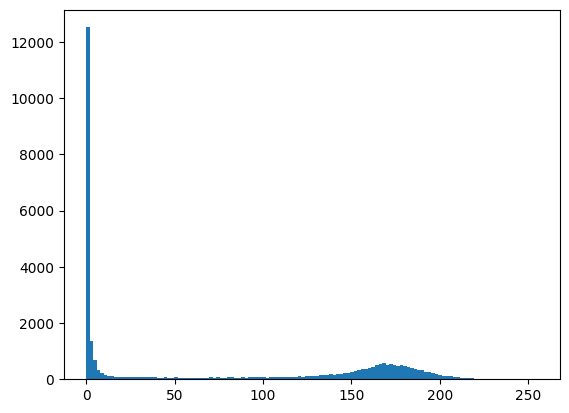

In [20]:
# Show the histogram of the flattened contours of the first image in the dataset without preserved aspect ratio.
figure()
hist(img_list[0].flatten(), 128)
show()

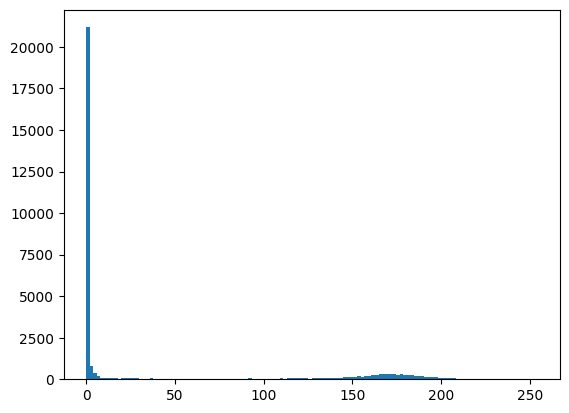

In [21]:
# Show the histogram of the flattened contours of the first image in the dataset with preserved aspect ratio.
figure()
hist(img_list_aspect_preserved[0].flatten(), 128)
show()

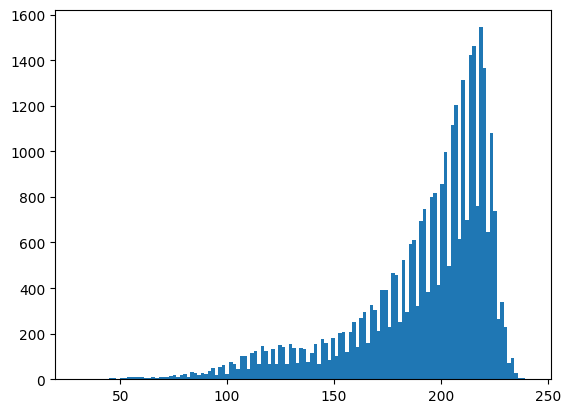

In [22]:
# Show the histogram of the flattened contours of the last image in the dataset without preserved aspect ratio.
figure()
hist(img_list[3574].flatten(), 128)
show()

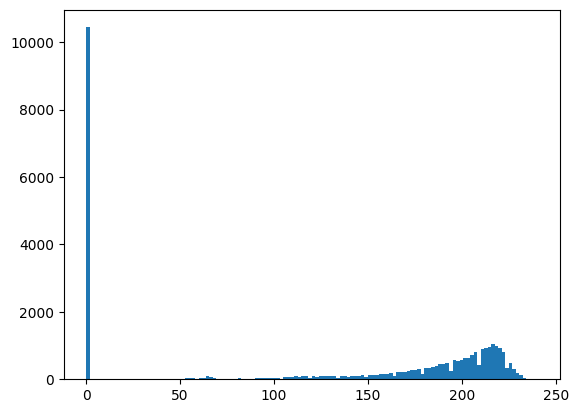

In [23]:
# Show the histogram of the flattened contours of the last image in the dataset with preserved aspect ratio.
figure()
hist(img_list_aspect_preserved[3574].flatten(), 128)
show()

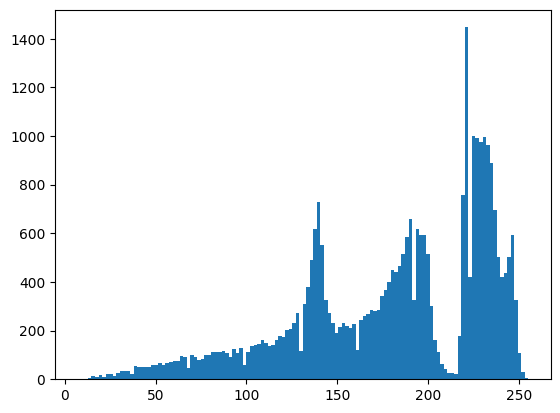

In [24]:
# Show the historgram of the flattened contours of the bent_pyramid_for_senefru image without preserved aspect ratio.
figure()
hist(img_list[194].flatten(), 128)
show()

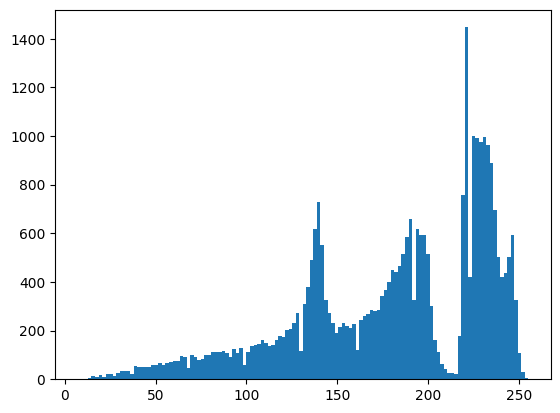

In [25]:
# Show the historgram of the flattened contours of the bent_pyramid_for_senefru image with preserved aspect ratio.
figure()
hist(img_list_aspect_preserved[194].flatten(), 128)
show()

# Spliting the data

In [26]:
# Split the DataFrame for train and test sets (non-aspect preserved)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)

# Extract image paths and labels for training and testing sets
X_train = []
y_train = []
for index, row in df_train.iterrows():
    image_path = row["image"]
    label = row["label"]
    X_train.append(img_list[index])  # Access corresponding image from non-aspect preserved NumPy array list
    y_train.append(label)

X_test = []
y_test = []
for index, row in df_test.iterrows():
    image_path = row["image"]
    label = row["label"]
    X_test.append(img_list[index])
    y_test.append(label)

# Convert lists to NumPy arrays for easier handling
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape images to 2D (samples x features) before applying PCA
X_train = X_train.reshape(-1, 180 * 180)  # Each image is 180x180
X_test = X_test.reshape(-1, 180 * 180)

print("X_train shape (reshaped):", X_train.shape)

X_train shape: (2502, 180, 180)
y_train shape: (2502,)
X_test shape: (1073, 180, 180)
y_test shape: (1073,)
X_train shape (reshaped): (2502, 32400)


# Dimensionality reduction - PCA

In [30]:
# Perform PCA (non-aspect preserved)
pca = PCA(n_components=100, random_state=22)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original shape: {}".format(str(X_train.shape)))
print("Reduced shape: {}".format(str(X_train_pca.shape)))

print("\n Original shape: {}".format(str(X_test.shape)))
print("Reduced shape: {}".format(str(X_test_pca.shape)))

Original shape: (2502, 32400)
Reduced shape: (2502, 100)

 Original shape: (1073, 32400)
Reduced shape: (1073, 100)


C:\Users\rsant\AppData\Local\Temp\ipykernel_17876\2837980048.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_colors)
C:\Users\rsant\AppData\Local\Temp\ipykernel_17876\2837980048.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cmap(y_train_int), cmap=cmap)


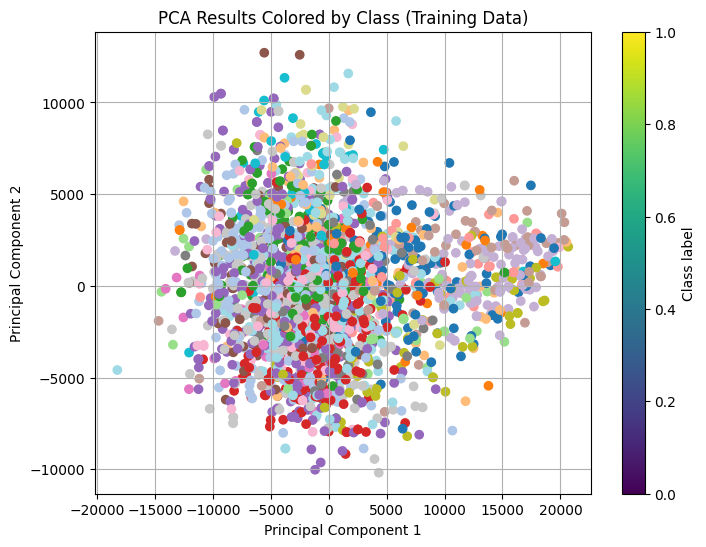

In [36]:
# Getting unique labels for colormap
unique_labels = np.unique(y_train)

label_to_int = {label: i for i, label in enumerate(unique_labels)}
y_train_int = np.array([label_to_int[label] for label in y_train])  # Encode labels numerically

num_colors = len(unique_labels)
cmap = cm.get_cmap('tab20', num_colors)

# Plot PCA results of X_train
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cmap(y_train_int), cmap=cmap)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Results Colored by Class (Training Data)")
plt.grid(True)
plt.colorbar(label="Class label")
plt.show()

# K-means Clustering

c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


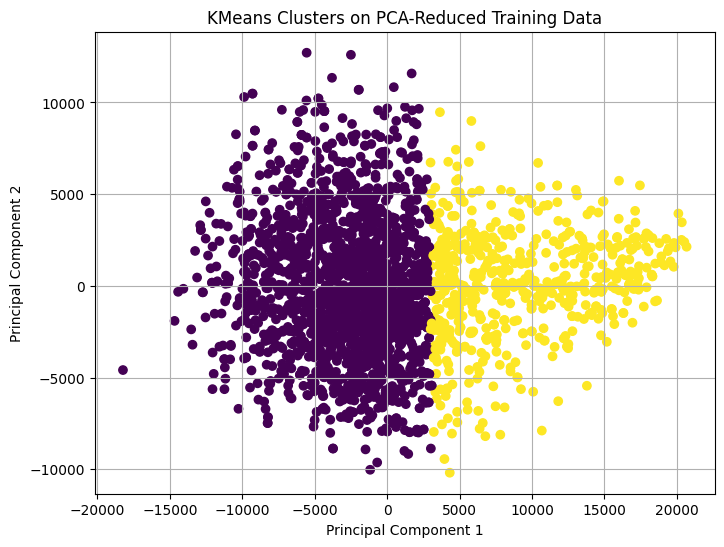

In [38]:
# build the clustering model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

# Predict cluster labels for training and testing data
y_train_kmeans = kmeans.predict(X_train_pca)
y_test_kmeans = kmeans.predict(X_test_pca)

# Create a scatter plot for training data colored by cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_kmeans, cmap="viridis")  # Adjust colors if needed
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans Clusters on PCA-Reduced Training Data")
plt.grid(True)
plt.show()

# You can create a similar plot for the test data using y_test_kmeans

## Continuing this project

In order to continue working on the project, the following questions need to be answered:

* How do I tell the algorithm to cluster into 2 groups, sculpture and structure, in an unsupervised approach?
    * How can it decipher that an image is a structure or sculpture?
* Should the set up of a CNN or pixel boundaries be done in at this step?